# **Ants vs Bees**

Two classes using DenseNet 161

In [0]:
%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Load dataset

## Load & unzip directory

In [4]:
# upload zip file
from google.colab import files

uploaded = files.upload()

Saving hymenoptera_data.zip to hymenoptera_data.zip


In [0]:
!unzip hymenoptera_data.zip

In [6]:
!rm hymenoptera_data.zip
!ls

hymenoptera_data  sample_data


## Create data loaders

In [0]:
data_transforms = {
    # Data augmentation and normalization for training
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Just normalization for validation
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize data

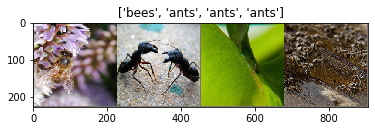

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Perform Transfer Learning

Steps:

1. Load in a pre-trained CNN model trained on a large dataset

2. Freeze parameters (weights) in model’s lower convolutional layers

3. Add custom classifier with several layers of trainable parameters to model

4. Train classifier layers on training data available for task

5. Fine-tune hyperparameters and unfreeze more layers if needed

## Define functions for training and visualisation

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # set almost a benchmark
    since = time.time()

    # save accuracy & loss for later
    accuracies = np.zeros((2, num_epochs))
    losses = np.zeros((2, num_epochs))

    # save weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for i, phase in enumerate(['train', 'val']):
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print accuracy
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # save accuracy
            accuracies[i, epoch] = epoch_acc
            losses[i, epoch] = epoch_loss

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # benchmarks :]
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, accuracies, losses

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    image_count = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                image_count += 1
                ax = plt.subplot(num_images//2, 2, image_count)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if image_count == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Load pretrained model, freeze the weights & redefine  FC layer

In [0]:
# load model
resnet = models.resnet152(pretrained=True)

# freeze weights 
for param in resnet.parameters():
    param.requires_grad = False


# reset fully connected part
num_features = resnet.fc.in_features  # 2048
# resnet.fc = nn.Linear(num_features, 2)
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 2)
)

# send it to cuda
resnet = resnet.to(device)

In [0]:
# define criterion, optimizer & lr sheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001) #, momentum=0.9)
sheduler = lr_scheduler.StepLR(optimizer, step_size=7, last_epoch=-1)

## Train, test & visualize transferred model

In [42]:
epochs = 50
resnet, accuracies, losses = train_model(
    resnet,
    criterion, 
    optimizer,
    sheduler,
    num_epochs = epochs
)

Epoch 0/49
----------
train Loss: 0.5889 Acc: 0.7623
val Loss: 0.4000 Acc: 0.9281

Epoch 1/49
----------
train Loss: 0.5056 Acc: 0.8484
val Loss: 0.3900 Acc: 0.9412

Epoch 2/49
----------
train Loss: 0.4952 Acc: 0.8361
val Loss: 0.3969 Acc: 0.9412

Epoch 3/49
----------
train Loss: 0.4777 Acc: 0.8525
val Loss: 0.3905 Acc: 0.9412

Epoch 4/49
----------
train Loss: 0.4908 Acc: 0.8156
val Loss: 0.3990 Acc: 0.9281

Epoch 5/49
----------
train Loss: 0.4778 Acc: 0.8566
val Loss: 0.4027 Acc: 0.9150

Epoch 6/49
----------
train Loss: 0.4943 Acc: 0.8402
val Loss: 0.3899 Acc: 0.9608

Epoch 7/49
----------
train Loss: 0.4694 Acc: 0.8525
val Loss: 0.3946 Acc: 0.9412

Epoch 8/49
----------
train Loss: 0.4846 Acc: 0.8361
val Loss: 0.3976 Acc: 0.9412

Epoch 9/49
----------
train Loss: 0.5162 Acc: 0.8115
val Loss: 0.3922 Acc: 0.9346

Epoch 10/49
----------
train Loss: 0.5090 Acc: 0.7992
val Loss: 0.3893 Acc: 0.9281

Epoch 11/49
----------
train Loss: 0.5009 Acc: 0.8320
val Loss: 0.3870 Acc: 0.9346

Ep

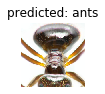

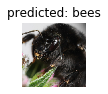

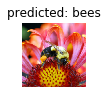

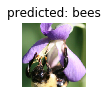

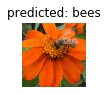

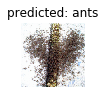

In [44]:
visualize_model(resnet)

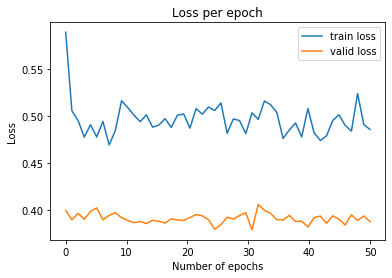

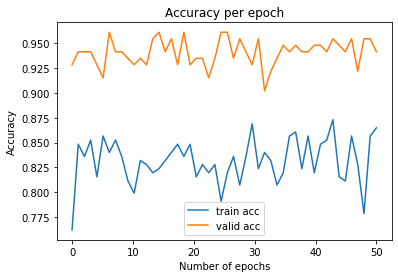

In [45]:
# plot accuracy
x = np.linspace(0, epochs, epochs)

plt.plot(x, losses[0,:], label="train loss")
plt.plot(x, losses[1,:], label="valid loss")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

plt.plot(x, accuracies[0,:], label="train acc")
plt.plot(x, accuracies[1,:], label="valid acc")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()